In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In /opt/conda/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/conda/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/conda/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /opt/conda/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/conda/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.

In [2]:
import torch
import torch.nn as nn

if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f"# DEVICE {i}: {torch.cuda.get_device_name(i)}")
        print("- Memory Usage:")
        print(f"  Allocated: {round(torch.cuda.memory_allocated(i)/1024**3,1)} GB")
        print(f"  Cached:    {round(torch.cuda.memory_cached(i)/1024**3,1)} GB\n")
        
else:
    print("# GPU is not available")

# DEVICE 0: Tesla V100-PCIE-32GB
- Memory Usage:
  Allocated: 0.0 GB
  Cached:    0.0 GB

# DEVICE 1: Tesla V100-PCIE-32GB
- Memory Usage:
  Allocated: 0.0 GB
  Cached:    0.0 GB

# DEVICE 2: Tesla V100-PCIE-32GB
- Memory Usage:
  Allocated: 0.0 GB
  Cached:    0.0 GB



/opt/conda/lib/python3.7/site-packages/torch/cuda/memory.py:346: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)


In [3]:
# GPU 할당 변경하기
GPU_NUM = 2 # 원하는 GPU 번호 입력
device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device) # change allocation of current GPU

print ('# Current cuda device: ', torch.cuda.current_device()) # check

# Current cuda device:  2


In [4]:
if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    print(f"using cuda: {GPU_NUM}, {torch.cuda.get_device_name(GPU_NUM)}")

using cuda: 2, Tesla V100-PCIE-32GB


In [5]:
from torch.utils.data import Dataset

class MnistDataset(Dataset):
    def __init__(self, csv_file):
        self.data_df = pd.read_csv(csv_file, header=None)
        pass
    
    def __len__(self):
        return len(self.data_df)
    
    def __getitem__(self, index):
        label = self.data_df.iloc[index, 0]
        target = torch.zeros((10))
        target[label] = 1.0
        
        image_values = torch.Tensor(self.data_df.iloc[index, 1:].values)/255.0
        
        return label, image_values, target
    
    def plot_image(self, index):
        img = self.data_df.iloc[index, 1:].values.reshape(28, 28)
        plt.title(f"label = {self.data_df.iloc[index, 0]}")
        plt.imshow(img, interpolation='none', cmap='Blues')
        

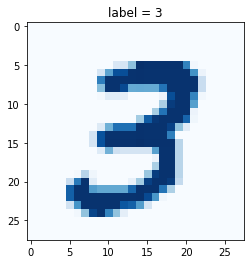

In [6]:
mnist_dataset = MnistDataset("./myo_gan/mnist_train.csv")
mnist_dataset.plot_image(7)

In [7]:
def generate_random_image(size):
    random_data = torch.rand(size)
    return random_data

def generate_random_seed(size):
    random_data = torch.randn(size)
    return random_data

In [8]:
generate_random_image(10)

tensor([0.0778, 0.8825, 0.5196, 0.8964, 0.4791, 0.2754, 0.6286, 0.9650, 0.1049,
        0.4235])

In [9]:
generate_random_seed(10)

tensor([ 1.6292, -0.5263, -0.5581, -0.7015,  0.3446, -2.2417,  1.4025,  0.4559,
         0.3151,  0.0390])

In [10]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Linear(784, 200),
            nn.LeakyReLU(0.02),
            nn.LayerNorm(200),
            nn.Linear(200, 1),
            nn.Sigmoid()
        )
        self.model = self.model.cuda()
        
        self.loss_function = nn.BCELoss()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.0001)
        
        self.counter = 0
        self.progress = []
        
    def forward(self, inputs):
        return self.model(inputs)
    
    def train(self, inputs, targets):
        outputs = self.forward(inputs)
        
        loss = self.loss_function(outputs, targets)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.counter += 1
        if self.counter % 10 == 0:
            self.progress.append(loss.item())
        if self.counter % 10000 == 0:
            print(f"counter= {self.counter}")
            
    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns=["loss"])
        df.plot(ylim=(0), figsize=(16, 8), alpha=0.1, marker=".", grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))

In [11]:
D = Discriminator()

for label, image_data_tensor, target_tensor in mnist_dataset:
    # real data
    D.train(image_data_tensor, torch.Tensor([1.0]))
    
    # fake data
    D.train(generate_random_image(784), torch.Tensor([0.0]))
    

counter= 10000
counter= 20000
counter= 30000
counter= 40000
counter= 50000
counter= 60000
counter= 70000
counter= 80000
counter= 90000
counter= 100000
counter= 110000
counter= 120000


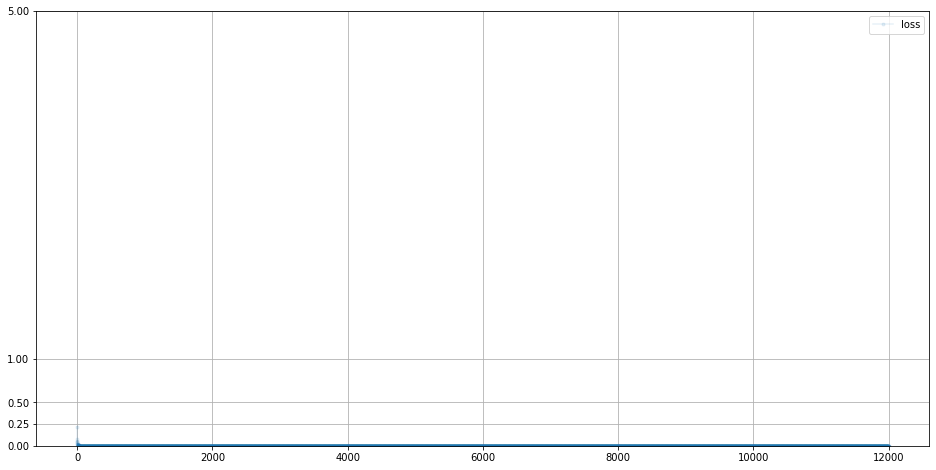

In [12]:
D.plot_progress()

In [13]:
import random

for i in range(4):
    image_data_tensor = mnist_dataset[random.randint(0, 60000)][1]
    print(D.forward(image_data_tensor).item())

1.0
1.0
1.0
1.0


In [14]:
for i in range(4):
    print(D.forward(generate_random_image(784)).item())

8.421311391282327e-12
8.729162358223075e-12
9.14939304874629e-12
8.334288120748212e-12


In [15]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Linear(100, 200),
            nn.LeakyReLU(0.02),
            nn.LayerNorm(200),
            nn.Linear(200, 784),
            nn.Sigmoid()
        )
        self.model = self.model.cuda()
        
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.0001)
        
        self.counter = 0
        self.progress = []
        
    def forward(self, inputs):
        return self.model(inputs)
    
    def train(self, D, inputs, targets):
        g_output = self.forward(inputs)
        
        d_output = D.forward(g_output)
        
        loss = D.loss_function(d_output, targets)
        
        self.counter += 1
        if self.counter % 10 == 0:
            self.progress.append(loss.item())
            
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns=["loss"])
        df.plot(ylim=(0), figsize=(16, 8), alpha=0.1, marker=".", grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        

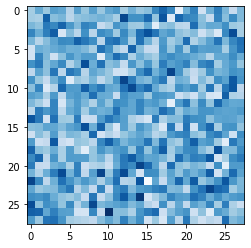

In [16]:
G = Generator()

output = G.forward(generate_random_seed(100))
img = output.cpu().detach().numpy().reshape(28, 28)
plt.imshow(img, cmap="Blues")

In [17]:
%%time

D = Discriminator()
G = Generator()

epochs = 4

for epoch in range(epochs):
    print(f"epoch= {epoch+1}")
    
    for label, image_data_tensor, target_tensor in mnist_dataset:
        D.train(image_data_tensor, torch.Tensor([1.0]))
        D.train(G.forward(generate_random_seed(100)).detach(), torch.Tensor([0.0]))
        G.train(D, generate_random_seed(100), torch.Tensor([1.0]))

epoch= 1
counter= 10000
counter= 20000
counter= 30000
counter= 40000
counter= 50000
counter= 60000
counter= 70000
counter= 80000
counter= 90000
counter= 100000
counter= 110000
counter= 120000
epoch= 2
counter= 130000
counter= 140000
counter= 150000
counter= 160000
counter= 170000
counter= 180000
counter= 190000
counter= 200000
counter= 210000
counter= 220000
counter= 230000
counter= 240000
epoch= 3
counter= 250000
counter= 260000
counter= 270000
counter= 280000
counter= 290000
counter= 300000
counter= 310000
counter= 320000
counter= 330000
counter= 340000
counter= 350000
counter= 360000
epoch= 4
counter= 370000
counter= 380000
counter= 390000
counter= 400000
counter= 410000
counter= 420000
counter= 430000
counter= 440000
counter= 450000
counter= 460000
counter= 470000
counter= 480000
CPU times: user 28min 8s, sys: 25.5 s, total: 28min 34s
Wall time: 28min 45s


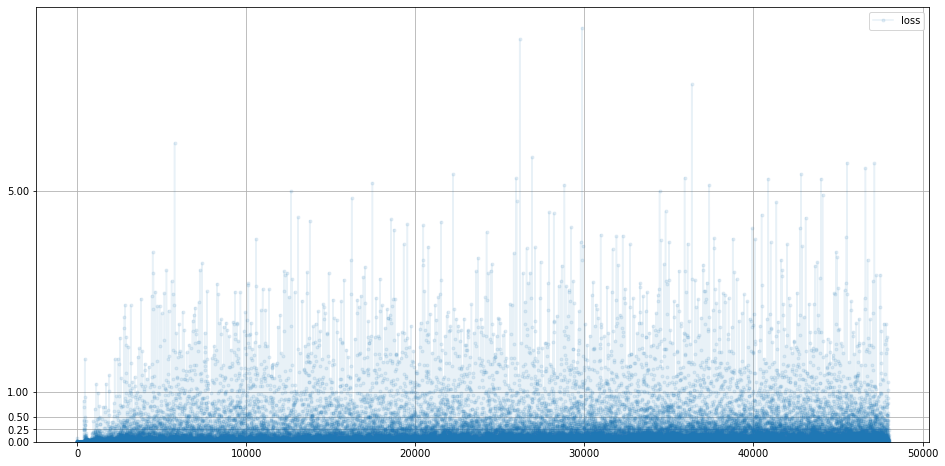

In [18]:
D.plot_progress()

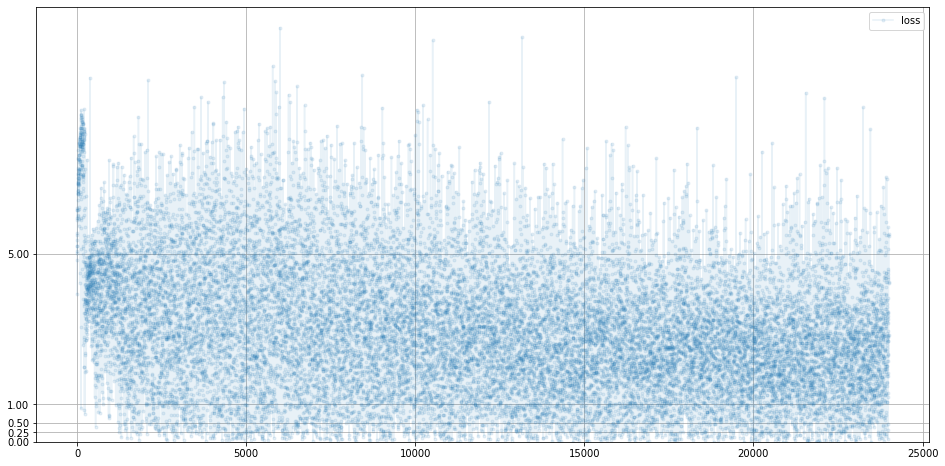

In [19]:
G.plot_progress()

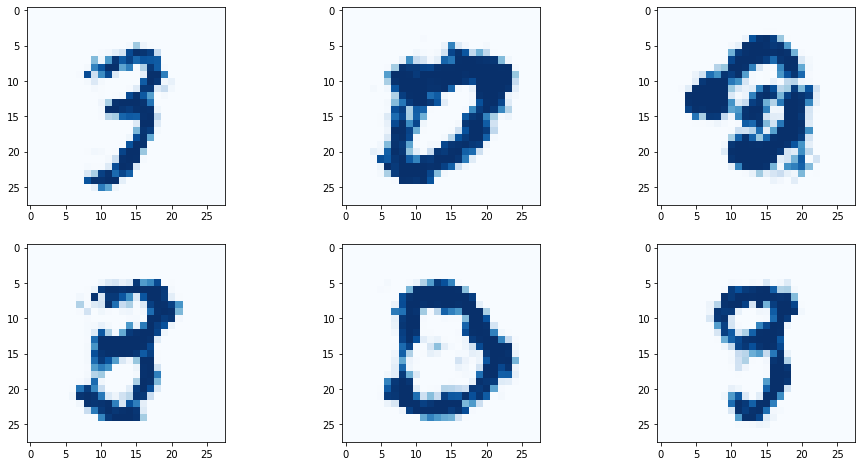

In [20]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(16, 8))
for ax in axes.ravel():
    output = G.forward(generate_random_seed(100))
    img = output.cpu().detach().numpy().reshape(28, 28)
    ax.imshow(img, cmap="Blues")

In [21]:
### conditional GAN

In [22]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Linear(784+10, 200),
            nn.LeakyReLU(0.02),
            nn.LayerNorm(200),
            nn.Linear(200, 1),
            nn.Sigmoid()
        )
        self.model = self.model.cuda()
        
        self.loss_function = nn.BCELoss()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.0001)
        
        self.counter = 0
        self.progress = []
        
    def forward(self, image_tensor, label_tensor):
        inputs = torch.cat((image_tensor, label_tensor))
        return self.model(inputs)
    
    def train(self, inputs, label_tensor, targets):
        outputs = self.forward(inputs, label_tensor)
        
        loss = self.loss_function(outputs, targets)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.counter += 1
        if self.counter % 10 == 0:
            self.progress.append(loss.item())
        if self.counter % 10000 == 0:
            print(f"counter= {self.counter}")
            
    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns=["loss"])
        df.plot(ylim=(0), figsize=(16, 8), alpha=0.1, marker=".", grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))

In [23]:
def generate_random_one_hot(size):
    label_tensor = torch.zeros((size))
    random_idx = random.randint(0, size-1)
    label_tensor[random_idx] = 1.0
    return label_tensor

In [24]:
D = Discriminator()

for label, image_data_tensor, label_tensor in mnist_dataset:
    D.train(image_data_tensor, label_tensor, torch.Tensor([1.0]))
    D.train(generate_random_image(784), generate_random_one_hot(10), torch.Tensor([0.0]))

counter= 10000
counter= 20000
counter= 30000
counter= 40000
counter= 50000
counter= 60000
counter= 70000
counter= 80000
counter= 90000
counter= 100000
counter= 110000
counter= 120000


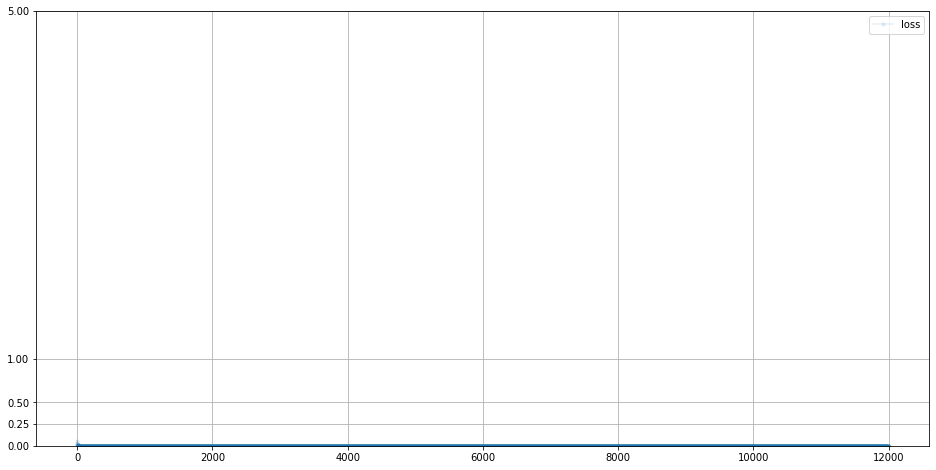

In [25]:
D.plot_progress()

In [26]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Linear(100+10, 200),
            nn.LeakyReLU(0.02),
            nn.LayerNorm(200),
            nn.Linear(200, 784),
            nn.Sigmoid()
        )
        self.model = self.model.cuda()
        
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.0001)
        
        self.counter = 0
        self.progress = []
        
    def forward(self, seed_tensor, label):
        inputs = torch.cat((seed_tensor, label))
        return self.model(inputs)
    
    def train(self, D, inputs, label_tensor, targets):
        g_output = self.forward(inputs, label_tensor)
        
        d_output = D.forward(g_output, label_tensor)
        
        loss = D.loss_function(d_output, targets)
        
        self.counter += 1
        if self.counter % 10 == 0:
            self.progress.append(loss.item())
            
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns=["loss"])
        df.plot(ylim=(0), figsize=(16, 8), alpha=0.1, marker=".", grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        
    def plot_images(self, label):
        label_tensor = torch.zeros((10))
        label_tensor[label] = 1.0

        fig, axes = plt.subplots(2, 3, figsize=(16, 8))
        for ax in axes.ravel():
            ax.imshow(G.forward(generate_random_seed(100), label_tensor).detach().cpu().numpy().reshape(28, 28), cmap="Blues")

In [27]:
D = Discriminator()
G = Generator()

epochs = 12
for epoch in range(epochs):
    for label, image_data_tensor, label_tensor in mnist_dataset:
        D.train(image_data_tensor, label_tensor, torch.Tensor([1.0]))

        random_label = generate_random_one_hot(10)
        D.train(G.forward(generate_random_seed(100), random_label).detach(), random_label, torch.Tensor([0.0]))

        random_label = generate_random_one_hot(10)
        G.train(D, generate_random_seed(100), random_label, torch.Tensor([1.0]))
    

counter= 10000
counter= 20000
counter= 30000
counter= 40000
counter= 50000
counter= 60000
counter= 70000
counter= 80000
counter= 90000
counter= 100000
counter= 110000
counter= 120000
counter= 130000
counter= 140000
counter= 150000
counter= 160000
counter= 170000
counter= 180000
counter= 190000
counter= 200000
counter= 210000
counter= 220000
counter= 230000
counter= 240000
counter= 250000
counter= 260000
counter= 270000
counter= 280000
counter= 290000
counter= 300000
counter= 310000
counter= 320000
counter= 330000
counter= 340000
counter= 350000
counter= 360000
counter= 370000
counter= 380000
counter= 390000
counter= 400000
counter= 410000
counter= 420000
counter= 430000
counter= 440000
counter= 450000
counter= 460000
counter= 470000
counter= 480000
counter= 490000
counter= 500000
counter= 510000
counter= 520000
counter= 530000
counter= 540000
counter= 550000
counter= 560000
counter= 570000
counter= 580000
counter= 590000
counter= 600000
counter= 610000
counter= 620000
counter= 630000
c

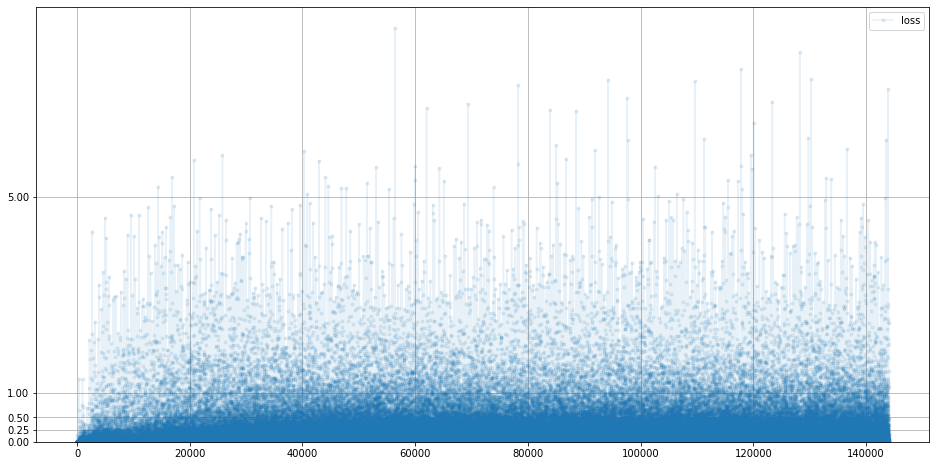

In [28]:
D.plot_progress()

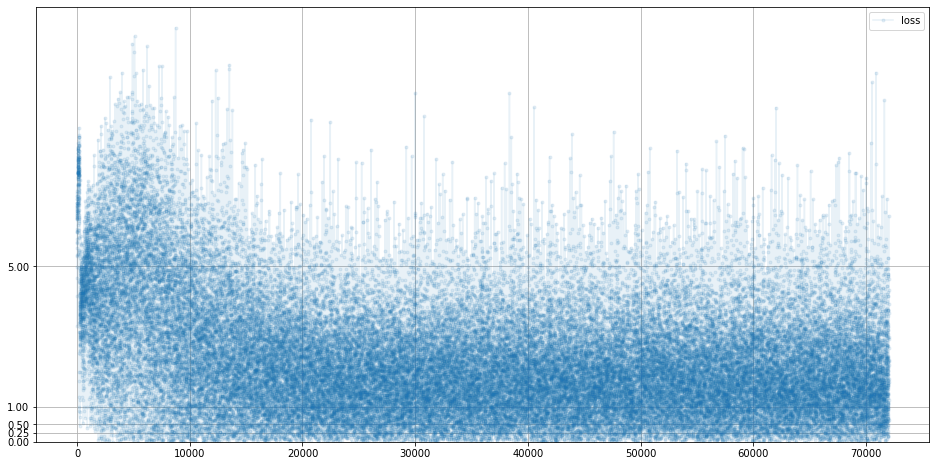

In [29]:
G.plot_progress()

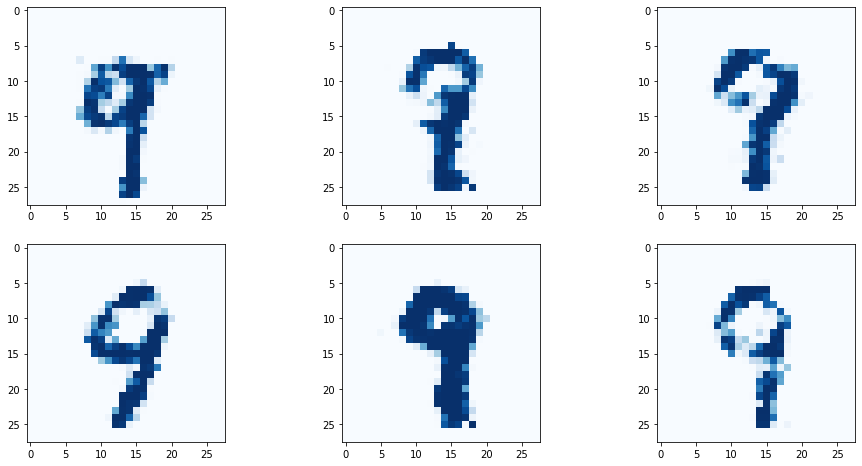

In [30]:
G.plot_images(9)

In [31]:
# generator class

class Generator(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        self.model = nn.Sequential(
            nn.Linear(100+10, 200),
            nn.LeakyReLU(0.02),

            nn.LayerNorm(200),

            nn.Linear(200, 784),
            nn.Sigmoid()
        )
        self.model = self.model.cuda()
        
        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []
        
        pass
    
    
    def forward(self, seed_tensor, label_tensor):        
        # combine seed and label
        inputs = torch.cat((seed_tensor, label_tensor))
        return self.model(inputs)


    def train(self, D, inputs, label_tensor, targets):
        # calculate the output of the network
        g_output = self.forward(inputs, label_tensor)
        
        # pass onto Discriminator
        d_output = D.forward(g_output, label_tensor)
        
        # calculate error
        loss = D.loss_function(d_output, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    def plot_images(self, label):
        label_tensor = torch.zeros((10))
        label_tensor[label] = 1.0
        # plot a 3 column, 2 row array of sample images
        f, axarr = plt.subplots(2,3, figsize=(16,8))
        for i in range(2):
            for j in range(3):
                axarr[i,j].imshow(G.forward(generate_random_seed(100), label_tensor).detach().cpu().numpy().reshape(28,28), interpolation='none', cmap='Blues')
                pass
            pass
        pass
    
    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass
    
    pass

In [32]:
# create Discriminator and Generator

D = Discriminator()
G = Generator()

In [33]:
%%time 

# train Discriminator and Generator

epochs = 12

for epoch in range(epochs):
    print ("epoch = ", epoch + 1)

    # train Discriminator and Generator

    for label, image_data_tensor, label_tensor in mnist_dataset:
        # train discriminator on true
        D.train(image_data_tensor, label_tensor, torch.Tensor([1.0]))

        # random 1-hot label for generator
        random_label = generate_random_one_hot(10)

        # train discriminator on false
        # use detach() so gradients in G are not calculated
        D.train(G.forward(generate_random_seed(100), random_label).detach(), random_label, torch.Tensor([0.0]))

        # different random 1-hot label for generator
        random_label = generate_random_one_hot(10)

        # train generator
        G.train(D, generate_random_seed(100), random_label, torch.Tensor([1.0]))

        pass

    pass

epoch =  1
counter= 10000
counter= 20000
counter= 30000
counter= 40000
counter= 50000
counter= 60000
counter= 70000
counter= 80000
counter= 90000
counter= 100000
counter= 110000
counter= 120000
epoch =  2
counter= 130000
counter= 140000
counter= 150000
counter= 160000
counter= 170000
counter= 180000
counter= 190000
counter= 200000
counter= 210000
counter= 220000
counter= 230000
counter= 240000
epoch =  3
counter= 250000
counter= 260000
counter= 270000
counter= 280000
counter= 290000
counter= 300000
counter= 310000
counter= 320000
counter= 330000
counter= 340000
counter= 350000
counter= 360000
epoch =  4
counter= 370000
counter= 380000
counter= 390000
counter= 400000
counter= 410000
counter= 420000
counter= 430000
counter= 440000
counter= 450000
counter= 460000
counter= 470000
counter= 480000
epoch =  5
counter= 490000
counter= 500000
counter= 510000
counter= 520000
counter= 530000
counter= 540000
counter= 550000
counter= 560000
counter= 570000
counter= 580000
counter= 590000
counter= 6

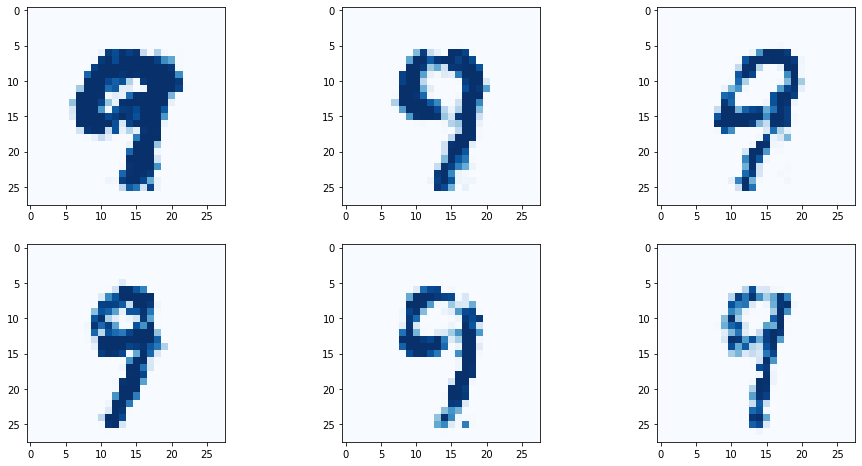

In [34]:
G.plot_images(9)